In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [2]:
df = pd.read_csv("data/_raw_df_channels.tsv.gz", sep='\t', parse_dates=["join_date"], index_col="channel")
df.category_cc = df.category_cc.astype("category")

In [3]:
df.dtypes

category_cc                 category
join_date             datetime64[ns]
name_cc                       object
subscribers_cc                 int64
videos_cc                      int64
subscriber_rank_sb           float64
dtype: object

In [4]:
df.head(10)

,category_cc,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb
channel,,,,,,
UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-05-21,MagnusNation,65100,28,231223.0
UCkNW9Q1VR_aeZ6uht83jJVQ,Entertainment,2011-12-13,Mago Dario Animazion...,60200,48,238538.0
UCXhkGgooXHDNwgJXmoTSN7g,Music,2008-03-17,Mago Merlino,14800,838,707828.0
UCvZGsuvKlYOGiZTsxwJNS5Q,Entertainment,2014-10-19,MAGO TOMÁS,26200,31,424550.0
UCxJWPpPED-J24znoKyKZYjg,Comedy,2017-01-15,Magog of Morskar,29400,158,422966.0
UCNNLaOkE-rcthxNssSHET2A,Gaming,2017-05-06,magoogala gaming,113000,106,148377.0
UCISF5OGuAtSLNF24TKTnXag,Film and Animation,2013-12-17,Magpiepony,736000,304,21120.0
UCRmRfTjSmzD1FQn3Iwp2fiQ,Science & Technology,2007-02-24,Magpul,86600,204,172090.0
UC1WpidoYChUGcyHAcnALQIg,Music,2011-05-28,magrosi65,64900,1497,219166.0


In [5]:
df.describe()

,subscribers_cc,videos_cc,subscriber_rank_sb
count,1.569770e+05,156977.000000,1.533300e+05
mean,2.415465e+05,700.634354,3.573119e+05
std,1.110144e+06,4439.410641,2.709194e+05
min,1.000000e+04,10.000000,3.000000e+00
25%,1.880000e+04,69.000000,1.165692e+05
50%,4.210000e+04,173.000000,3.025270e+05
75%,1.360000e+05,440.000000,5.707568e+05
max,1.121395e+08,461923.000000,1.101245e+06


<AxesSubplot:xlabel='subscribers_cc', ylabel='category_cc'>

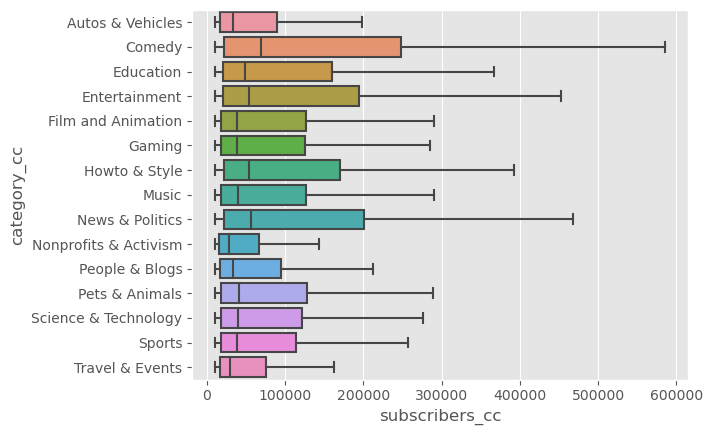

In [6]:
sns.boxplot(data=df, x=df.subscribers_cc, y=df.category_cc, showfliers = False)

In [7]:
df.groupby("category_cc").max("subscriber_cc")

,subscribers_cc,videos_cc,subscriber_rank_sb
category_cc,,,
Autos & Vehicles,8271583,82914,985789.0
Comedy,26400000,34405,998847.0
Education,60100000,118159,988795.0
Entertainment,56018869,257188,1007560.0
Film and Animation,29500000,125613,1007876.0
Gaming,101000000,169676,1009505.0
Howto & Style,60600000,332703,1005013.0
Music,112139463,175300,1101245.0
News & Politics,16274836,461923,983725.0


### Channel with most subscibers

In [8]:
df.loc[df['subscribers_cc'].idxmax()]

category_cc                         Music
join_date             2006-03-13 00:00:00
name_cc                          T-Series
subscribers_cc                  112139463
videos_cc                           13839
subscriber_rank_sb                  102.0
Name: UCq-Fj5jknLsUf-MWSy4_brA, dtype: object

### Channel with most videos

In [9]:
df.loc[df['videos_cc'].idxmax()]

category_cc               News & Politics
join_date             2015-06-17 00:00:00
name_cc                        AP Archive
subscribers_cc                    1770000
videos_cc                          461923
subscriber_rank_sb                 6059.0
Name: UCHTK-2W11Vh1V4uwofOfR4w, dtype: object